In [4]:
import numpy as np
import gym
from gym import spaces
from stable_baselines3 import SAC
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.callbacks import EvalCallback
import optuna
class MultiEnergySystemEnv(gym.Env):
    def __init__(self):
        super(MultiEnergySystemEnv, self).__init__()
        
        # 状态空间：电力需求、热需求、冷需求、储能SOC、风电、光伏
        self.observation_space = spaces.Box(low=0, high=1, shape=(6,), dtype=np.float32)
        
        # 动作空间：储能充放电功率[-1, 1]，碳捕集设备加载率[0, 1]
        self.action_space = spaces.Box(low=np.array([-1, 0]), high=np.array([1, 1]), dtype=np.float32)
        
        # 初始化状态
        self.state = self.reset()
        self.timestep = 0

        # 参数设置
        self.max_charge_power = 0.8   # 储能设备最大充电功率
        self.max_discharge_power = -0.8  # 储能设备最大放电功率
        self.soc_min = 0.1  # 储能最小SOC
        self.soc_max = 0.9  # 储能最大SOC
        self.soc_penalty_factor = 100  # SOC 约束违反的惩罚因子
        self.policy_incentive = 0.2  # 政策激励

    def reset(self):
        # 初始化状态
        self.timestep = 0
        self.state = np.random.uniform(0, 1, size=(6,))
        return self.state
    
    def step(self, action):
        """
        动作的执行：
        - action[0]: 储能充放电功率（-1到1)
        - action[1]: 碳捕集设备加载率(0到1)
        """
        power_demand, heat_demand, cooling_demand, soc, wind_power, pv_power = self.state
        storage_power = action[0]
        carbon_capture_rate = action[1]

        # 储能设备功率限制
        storage_power = np.clip(storage_power, self.max_discharge_power, self.max_charge_power)
        
        # 更新储能状态（SOC）
        new_soc = soc + storage_power * 0.05  # 模拟 SOC 变化
        soc_penalty = 0  # 初始化 SOC 惩罚

        # 如果 SOC 超过范围，计算惩罚
        if new_soc > self.soc_max:
            soc_penalty = -self.soc_penalty_factor * (new_soc - self.soc_max)  # 惩罚过充
            new_soc = self.soc_max  # SOC 被限制在上限
        elif new_soc < self.soc_min:
            soc_penalty = -self.soc_penalty_factor * (self.soc_min - new_soc)  # 惩罚过放
            new_soc = self.soc_min  # SOC 被限制在下限

        # 供需平衡
        renewable_supply = wind_power + pv_power + storage_power
        unmet_demand = max(0, power_demand + heat_demand + cooling_demand - renewable_supply)
        energy_balance_penalty = -unmet_demand  # 未满足需求的惩罚

        # 碳捕集成本（负向奖励）
        carbon_capture_cost = -0.1 * (carbon_capture_rate ** 2)

        # 政策激励
        policy_reward = 0
        if carbon_capture_rate >= 0.8:
            policy_reward = self.policy_incentive

        # 总奖励
        reward = energy_balance_penalty + carbon_capture_cost + policy_reward + soc_penalty
        
        # 更新状态
        self.state = np.random.uniform(0, 1, size=(6,))
        self.state[3] = new_soc  # 保留更新后的SOC状态
        self.timestep += 1
        
        # 结束条件
        done = self.timestep >= 200
        
        return self.state, reward, done, {}
    
    def render(self, mode='human'):
        pass


# 创建环境
env = DummyVecEnv([lambda: MultiEnergySystemEnv()])

# 使用Optuna优化超参数
def optimize_sac(trial):
    # 超参数搜索空间
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
    batch_size = trial.suggest_categorical('batch_size', [64, 128, 256])
    gamma = trial.suggest_uniform('gamma', 0.9, 0.99)
    
    # 初始化模型
    model = SAC("MlpPolicy", env, learning_rate=learning_rate, batch_size=batch_size, gamma=gamma, verbose=0)
    
    # 定义评估回调
    eval_callback = EvalCallback(env, eval_freq=500, n_eval_episodes=5, deterministic=True, verbose=0)
    
    # 训练模型
    model.learn(total_timesteps=5000, callback=eval_callback)
    
    # 返回评估奖励
    return eval_callback.last_mean_reward

# 使用Optuna调优超参数
study = optuna.create_study(direction='maximize')
study.optimize(optimize_sac, n_trials=10)

# 获取最佳超参数
best_params = study.best_params
print("Best Hyperparameters:", best_params)


e:\Pythonworkshop\DRL_work\.conda\lib\site-packages\gym\spaces\box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
e:\Pythonworkshop\DRL_work\.conda\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
[I 2024-11-27 15:31:47,423] A new study created in memory with name: no-name-e8d98b9d-bdf5-43d2-b762-63cd98729a11
C:\Users\bo.chen18\AppData\Local\Temp\ipykernel_22964\2846911118.py:97: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest

Best Hyperparameters: {'learning_rate': 0.0011511850532443526, 'batch_size': 64, 'gamma': 0.9378467003237855}


In [2]:
# 使用最佳超参数训练最终模型
final_model = SAC("MlpPolicy", env, learning_rate=best_params['learning_rate'], batch_size=best_params['batch_size'], gamma=best_params['gamma'], verbose=1)
final_model.learn(total_timesteps=10000)

Using cuda device
---------------------------------
| time/              |          |
|    episodes        | 4        |
|    fps             | 93       |
|    time_elapsed    | 8        |
|    total_timesteps | 800      |
| train/             |          |
|    actor_loss      | 0.194    |
|    critic_loss     | 0.118    |
|    ent_coef        | 0.0519   |
|    ent_coef_loss   | -6.28    |
|    learning_rate   | 0.00473  |
|    n_updates       | 699      |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 8        |
|    fps             | 88       |
|    time_elapsed    | 18       |
|    total_timesteps | 1600     |
| train/             |          |
|    actor_loss      | 1.53     |
|    critic_loss     | 0.136    |
|    ent_coef        | 0.0131   |
|    ent_coef_loss   | -0.815   |
|    learning_rate   | 0.00473  |
|    n_updates       | 1499     |
---------------------------------
------------------------------

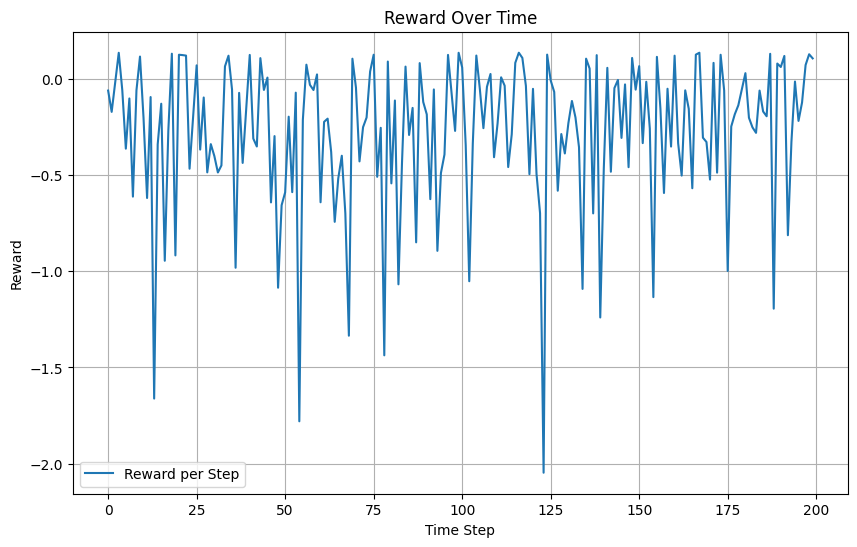

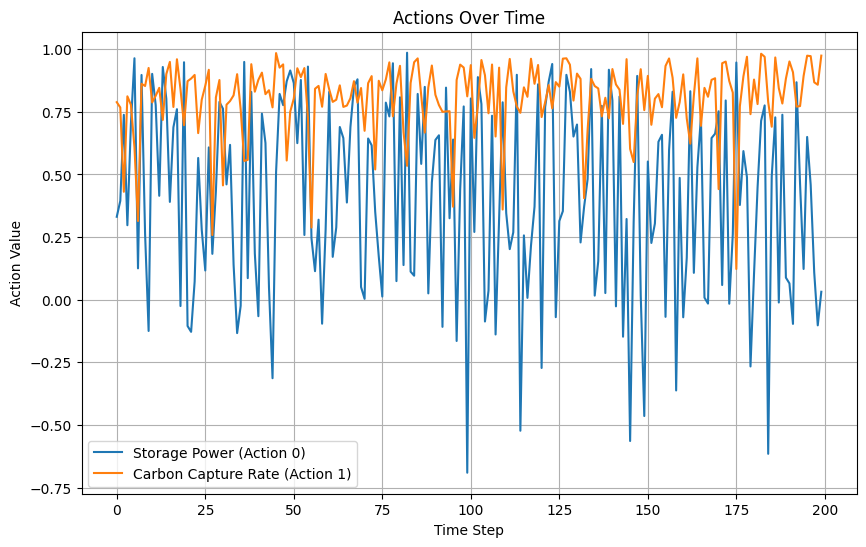

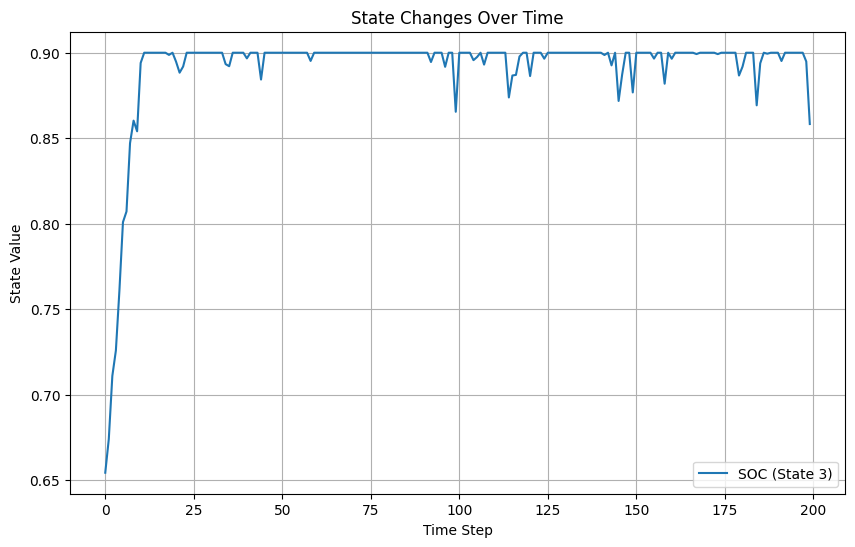

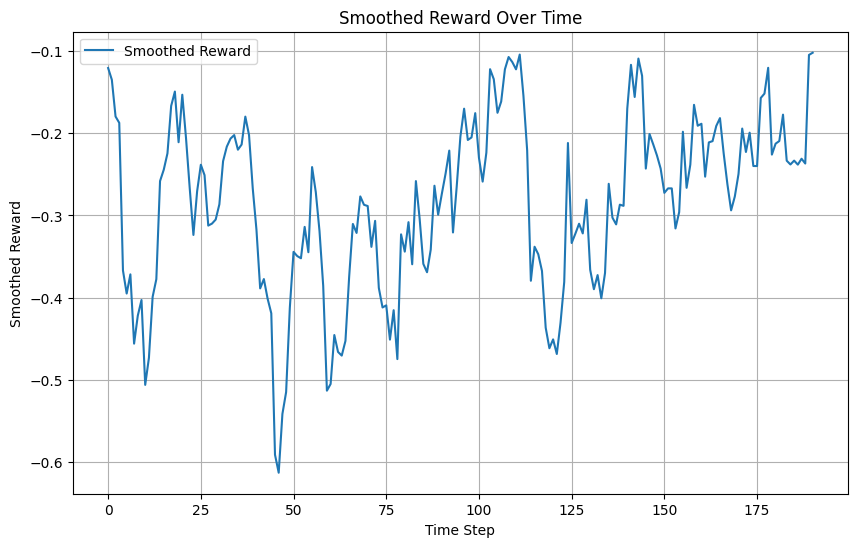

In [3]:
import numpy as np
import matplotlib.pyplot as plt
obs = env.reset()
# 初始化存储变量
rewards = []  
actions = []  
states = []   

# 测试模型
for _ in range(200):
    action, _states = final_model.predict(obs, deterministic=True)  
    obs, reward, done, info = env.step(action)                     
    actions.append(action.reshape(-1))                             
    rewards.append(reward)                                         
    states.append(obs.reshape(-1))                                    
    if done:
        break

actions = np.array(actions)
states = np.array(states)
if len(states.shape) == 1:  
    states = states.reshape(-1, 1)  

rewards = np.array(rewards)

# 奖励趋势
plt.figure(figsize=(10, 6))
plt.plot(rewards, label="Reward per Step")
plt.title("Reward Over Time")
plt.xlabel("Time Step")
plt.ylabel("Reward")
plt.legend()
plt.grid()
plt.show()

# 动作变化趋势
plt.figure(figsize=(10, 6))
plt.plot(actions[:, 0], label="Storage Power (Action 0)")
if actions.shape[1] > 1:  # 如果有多个动作
    plt.plot(actions[:, 1], label="Carbon Capture Rate (Action 1)")
plt.title("Actions Over Time")
plt.xlabel("Time Step")
plt.ylabel("Action Value")
plt.legend()
plt.grid()
plt.show()

#关键状态变量
plt.figure(figsize=(10, 6))

# 如果状态空间有多维，可以绘制储能状态 (SOC)
if states.shape[1] > 3:  # 确保第 4 列 (索引为 3) 存在
    plt.plot(states[:, 3], label="SOC (State 3)")  # 绘制储能设备状态 (SOC)
else:
    print("State dimension too small, cannot plot SOC.")

plt.title("State Changes Over Time")
plt.xlabel("Time Step")
plt.ylabel("State Value")
plt.legend()
plt.grid()
plt.show()


# 平滑奖励趋势
def moving_average(data, window_size):
    data = np.array(data).flatten() 
    return np.convolve(data, np.ones(window_size) / window_size, mode='valid')

# 平滑奖励曲线
rewards = np.array(rewards).flatten()
plt.figure(figsize=(10, 6))
plt.plot(moving_average(rewards, window_size=10), label="Smoothed Reward")
plt.title("Smoothed Reward Over Time")
plt.xlabel("Time Step")
plt.ylabel("Smoothed Reward")
plt.legend()
plt.grid()
plt.show()